In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,iplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LogisticRegression
from catboost import Pool, CatBoostClassifier, cv
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import average_precision_score,classification_report
from sklearn.ensemble import RandomForestClassifier
import optuna
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

C:\Users\araga\AppData\Local\Temp\ipykernel_10488\888196002.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#combining all tdcsfog '.csv' train files
tdcsfog_path= r'C:\Users\araga\.vscode\FoG Project (AI Scholars)\tlvmc-parkinsons-freezing-gait-prediction\train\tdcsfog'
tdcsfog_list= []

for file_name in os.listdir(tdcsfog_path):
    if file_name.endswith('.csv'):
        file_path= os.path.join(tdcsfog_path,file_name)
        df= pd.read_csv(file_path)
        df['Time']= df['Time']/(len(df)-1) 
        tdcsfog_list.append(df)
     
tdcsfog = pd.concat(tdcsfog_list,axis= 0)
tdcsfog

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,0.000000,-9.533939,0.566322,-1.413525,0,0,0
1,0.000214,-9.536140,0.564137,-1.440621,0,0,0
2,0.000427,-9.529345,0.561765,-1.429332,0,0,0
3,0.000641,-9.531239,0.564227,-1.415490,0,0,0
4,0.000855,-9.540825,0.561854,-1.429471,0,0,0
...,...,...,...,...,...,...,...
4220,0.999053,-9.403467,0.089003,-3.220304,0,0,0
4221,0.999290,-9.404246,0.090531,-3.216584,0,0,0
4222,0.999527,-9.405770,0.084380,-3.224039,0,0,0
4223,0.999763,-9.403579,0.084236,-3.236686,0,0,0


In [3]:
defog_path = r'C:\Users\araga\.vscode\FoG Project (AI Scholars)\tlvmc-parkinsons-freezing-gait-prediction\train\defog'

defog_list = []

for file_name in os.listdir(defog_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(defog_path, file_name)
        file = pd.read_csv(file_path)
        file.Time = file.Time / (len(file) - 1)
        defog_list.append(file)

defog = pd.concat(defog_list, axis = 0)

defog.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,0.000000,-1.0,0.044129,-0.25,0,0,0,False,False
1,0.000006,-1.0,0.034431,-0.25,0,0,0,False,False
2,0.000012,-1.0,0.031250,-0.25,0,0,0,False,False
3,0.000018,-1.0,0.031250,-0.25,0,0,0,False,False
4,0.000025,-1.0,0.031250,-0.25,0,0,0,False,False


In [4]:
print(defog.columns)
print(tdcsfog.columns)

defog= defog[(defog['Valid']==1) & (defog['Task']==1)]
defog.dropna()

Index(['Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn', 'Walking',
       'Valid', 'Task'],
      dtype='object')
Index(['Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn', 'Walking'], dtype='object')


,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
1000,0.006139,-0.970018,0.061626,-0.265625,0,0,0,True,True
1001,0.006145,-0.984375,0.044497,-0.265625,0,0,0,True,True
1002,0.006151,-0.984375,0.029016,-0.265625,0,0,0,True,True
1003,0.006157,-0.984375,0.015625,-0.265625,0,0,0,True,True
1004,0.006163,-0.984670,0.015330,-0.265625,0,0,0,True,True
...,...,...,...,...,...,...,...,...,...
119027,0.991635,-0.961216,0.142428,-0.289655,0,0,0,True,True
119028,0.991644,-0.960343,0.142836,-0.290506,0,0,0,True,True
119029,0.991652,-0.957958,0.145494,-0.290007,0,0,0,True,True
119030,0.991660,-0.960616,0.145839,-0.291527,0,0,0,True,True


In [5]:
defog= defog.iloc[:,:7]

In [6]:
merged= pd.concat([tdcsfog,defog],axis=0)
merged

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,0.000000,-9.533939,0.566322,-1.413525,0,0,0
1,0.000214,-9.536140,0.564137,-1.440621,0,0,0
2,0.000427,-9.529345,0.561765,-1.429332,0,0,0
3,0.000641,-9.531239,0.564227,-1.415490,0,0,0
4,0.000855,-9.540825,0.561854,-1.429471,0,0,0
...,...,...,...,...,...,...,...
119027,0.991635,-0.961216,0.142428,-0.289655,0,0,0
119028,0.991644,-0.960343,0.142836,-0.290506,0,0,0
119029,0.991652,-0.957958,0.145494,-0.290007,0,0,0
119030,0.991660,-0.960616,0.145839,-0.291527,0,0,0


Exploratory Data Analysis

<Axes: >

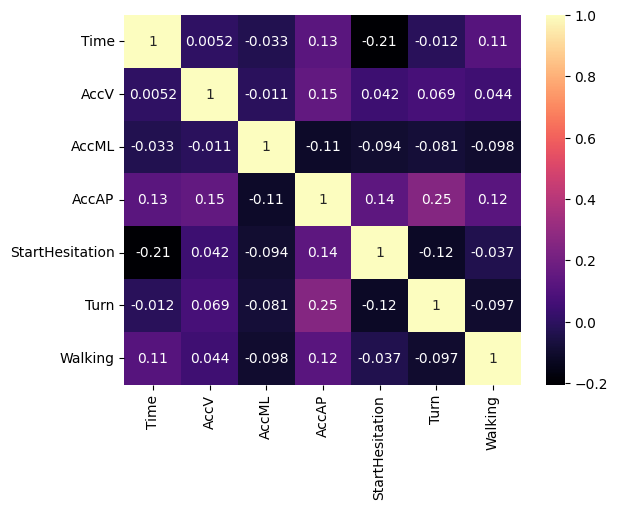

In [7]:
sns.heatmap(tdcsfog.corr(),annot= True,cmap='magma')

<Axes: xlabel='Number of 1s', ylabel='count'>

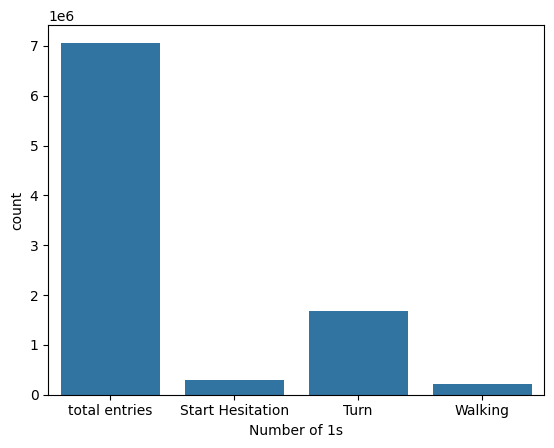

In [8]:
df2= pd.DataFrame(np.concatenate([
    ['total entries'] * len(tdcsfog),
    ['Start Hesitation'] *  int(tdcsfog['StartHesitation'].mean() * len(tdcsfog)),
    ['Turn'] * int(tdcsfog['Turn'].mean() * len(tdcsfog)),
    ['Walking'] * int(tdcsfog['Walking'].mean() * len(tdcsfog))]),
    columns= ['Number of 1s']              
    )

sns.countplot(data= df2, x='Number of 1s')

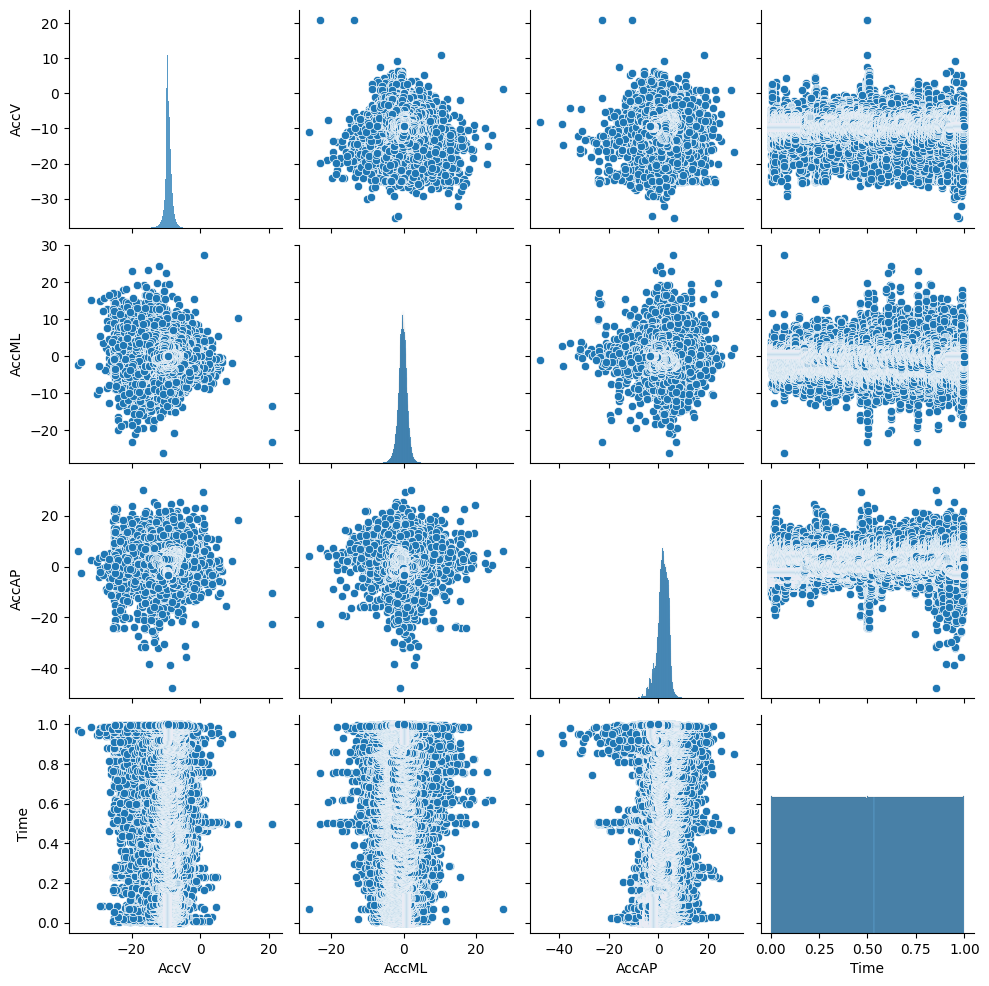

In [10]:
sns.pairplot(tdcsfog[['AccV','AccML','AccAP', "Time"]])

In [11]:
fig, ax = plt.subplots(figsize = (10, 6))
​
ax.plot(tdcsfog['Time'], tdcsfog['StartHesitation'], label = 'StartHesitation')
ax.plot(tdcsfog['Time'], tdcsfog['Turn'], label = 'Turn')
ax.plot(tdcsfog['Time'], tdcsfog['Walking'], label = 'Walking')
​
ax.set_xlabel('Time')
ax.set_ylabel('Binary Status(0 or 1)')
ax.set_title('Relationship between Time and Movement Status')
​
ax.legend(loc='upper left',bbox_to_anchor=(1,0.5))

SyntaxError: invalid non-printable character U+200B (1319680711.py, line 2)

Data Preparation

In [9]:
X_merged = merged.iloc[:,0:4]  
X = tdcsfog.iloc[:,0:4]  
y1 = merged['StartHesitation']  # target variable for StartHesitation
y2 = merged['Turn']  # target variable for Turn
y3 = tdcsfog['Walking']  # target variable for Walking
X_merged.head()

,Time,AccV,AccML,AccAP
0,0.000000,-9.533939,0.566322,-1.413525
1,0.000214,-9.536140,0.564137,-1.440621
2,0.000427,-9.529345,0.561765,-1.429332
3,0.000641,-9.531239,0.564227,-1.415490
4,0.000855,-9.540825,0.561854,-1.429471
